# Fast & slow modes

Volem resoldre el problema dels modes ràpid i lent de les equacios obtingudes a partir de la MHD ideal i de la linealització i posterior adimensionalització de les equacions.

Number of unknowns: 6
Number of equations: 6
2025-05-01 13:32:01,341 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 15s, Remaining: 0s, Rate: 6.6e-02/s
evals.size (before)  260
evals.size (after removing inf)  260
evals.size (after removing < 0)  260

evals size 260
true_evals size  260
First 5 Eigenvalues (sqrt): [ 2.64129611  7.66751287  8.7506866   9.31721416 13.73492167]
First 5 True eigenvalues: [ 2.66901857  7.37232117  7.55178196  9.34725317 13.9452195 ]
Relative error: [0.01038676 0.04004054 0.15875785 0.00321367 0.01508028]



/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_22639/1499188465.py:259: RuntimeWarning: invalid value encountered in divide
  ui = u['g'].imag/(u['g'][1]).imag
/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_22639/1499188465.py:260: RuntimeWarning: invalid value encountered in divide
  wi = w['g'].imag/(w['g'][1]).imag


Maximum value is from ug; max_val = 893.9141266305635
Maximum value is from wg; max_val = 1739.8555029558315
Maximum value is from wg; max_val = 967.9802761880916
Maximum value is from wg; max_val = 436.0444789570479


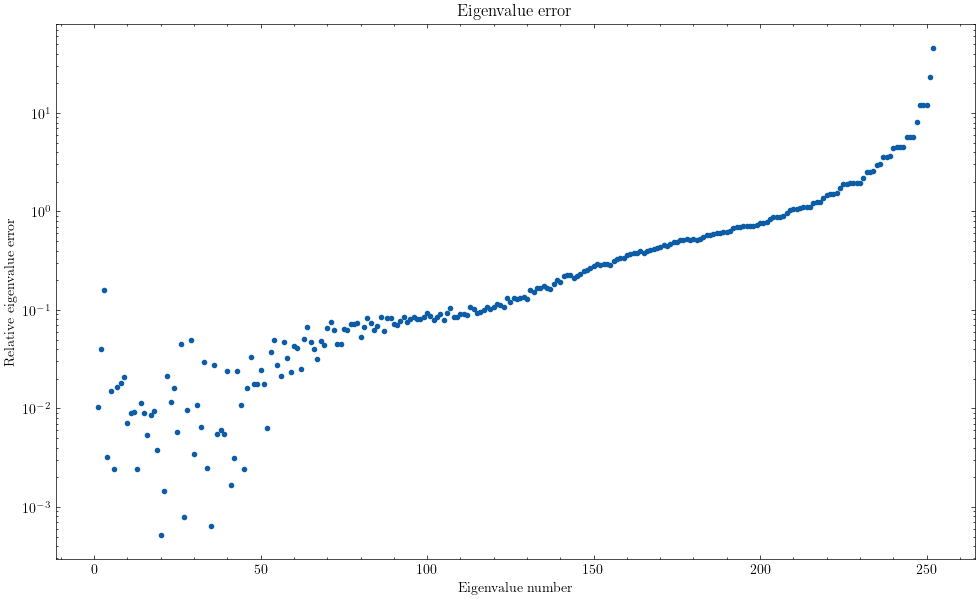

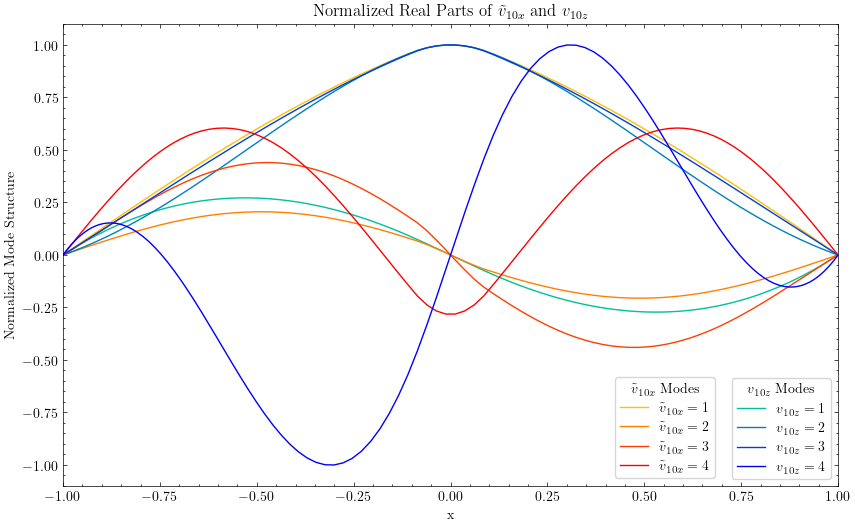

Valors normalitzats:


,Mode,ug_max,wg_max,ug_min,wg_min
0,Mode 1,1.000000,0.271971,0.000168,-0.271971
1,Mode 2,0.205632,1.000000,-0.205632,0.000083
2,Mode 3,0.440036,1.000000,-0.440036,0.000156
3,Mode 4,0.604523,1.000000,-0.281274,-1.000000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
logger = logging.getLogger(__name__)
from IPython.display import display
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

def dispersion_relation2(omega):
    disprel_even2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
    disprel_odd2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
    disprel2 = disprel_even2 * disprel_odd2
    return disprel2

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        sol2 = fsolve(dispersion_relation2, omega0)

        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        if sol2 > 0:
            exact_soln = np.append(exact_soln, sol2)
            exact_soln = np.unique(exact_soln.round(decimals=8))

        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
#    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln



""" Paràmetres """
Nx = 128 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]



""" Constants """
kz = 1
#B0 = 0

### Velocitats a trossos ###
cp2 = 1
cc2 = 6 # 6
vAp2 = 9 # 9
vAc2 = 36 # 36
# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768



""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ###
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis)

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Camps magnètics ###
#Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
#Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z

### Densitats ###
#rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma  ρ0
#rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
#rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')



""" Derivatives """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!

# RESOLDRE PRIMER SUBSTITUINT Bx, Bx i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w, eqs. (17') i (19')

# velocitat dedins menor que defora
# alfven major primer, després provar

# comparar amb kz = 0 les dues equacions han de ser ~ iguals
# provar amb kz = 0.01 i s'ha de modificar poc - petit acoblament de les velocitats



""" Problem """
### Problema d'ones ràpida i lenta (complet) ###
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

### Problema d'ones d'Alfvén ### ~ corda guitarra amb densitat variable
#problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)

### Problema d'ones ràpida i lenta (més treballat) ###
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals()) # 2 equacions i 4 incògnites
# problem.add_equation("s * u  +  c2 * uxx  =  0") # (17') # amb kz = 0
# problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0. Hauríem d'obtenir una molt semblant a la (17') però amb la velocitat en z i la constant d'Alfvén
problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))



""" Solve """
### Solver de Dedalus ###
solver = problem.build_solver()
#print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

### Ajustament de les autofuncions ###
print('evals.size (before) ', evals.size)
#evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

### Autovalors exactes ###
Nevals = evals.size
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
true_evals = exact_soln[0:evals.size]

### Error relatiu ###
relative_error = np.abs(evals - true_evals) / true_evals

### Autovalors ###
print('evals size', evals.size)
print("true_evals size ", true_evals.size)
#print("Evals", evals)
#print("True Evals", true_evals)

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])
print()  # This adds a blank line



""" Plot """
### Plot error ###
plt.figure(figsize=(10, 6))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Eigenvalue number")
plt.ylabel("Relative eigenvalue error")
plt.tight_layout()
plt.title("Eigenvalue error")
plt.grid(False)
plt.plot()



### Nombre de modes que volem representar ###
N_max_mode = 4
N_min_mode = 0
N_modes = N_max_mode - N_min_mode

### Define warm and cold color palettes ###
cmap_warm = plt.get_cmap('autumn')  # Warm color palette for v10x~
cmap_cold = plt.get_cmap('winter')   # Cold color palette for v10z
colors_warm = [cmap_warm(i / N_modes) for i in range(N_modes)]    # Warm colors
colors_cold = [cmap_cold(i / N_modes) for i in range(N_modes)]    # Cold colors

### Create lists to store handles for legends ###
handles_v10x = []
handles_v10z = []

### Plot ug.real and wg.real and normalize to the maximum value ###

x = dist.local_grid(xbasis)
ug_max_list = []
ug_min_list = []
wg_max_list = []
wg_min_list = []
plt.figure(figsize=(10, 6))
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag/(u['g'][1]).imag
    wi = w['g'].imag/(w['g'][1]).imag
    
    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is from ug; max_val =", max_val)
    else:
        print("Maximum value is from wg; max_val =", max_val)

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    # Append the values to the lists to display in the DataFrame
    ug_max_list.append(np.max(ug_normalized))
    ug_min_list.append(np.min(ug_normalized))
    wg_max_list.append(np.max(wg_normalized))
    wg_min_list.append(np.min(wg_normalized))

    # Plot v10x~ with warm colors and store the handle
    handle_v10x, = plt.plot(x, ug_normalized, label=fr"$\tilde{{v}}_{{10x}}={n}$", color=colors_warm[ - n])
    handles_v10x.append(handle_v10x)

    # Plot v10z with cold colors and store the handle
    handle_v10z, = plt.plot(x, wg_normalized, label=fr"${{v}}_{{10z}}={n}$", color=colors_cold[ - n])
    handles_v10z.append(handle_v10z)

    # Create a DataFrame to display the results
    data = {
        "Mode": [f"Mode {i+1}" for i in range(len(ug_max_list))],
        "ug_max": ug_max_list,
        "wg_max": wg_max_list,
        "ug_min": ug_min_list,
        "wg_min": wg_min_list,}
    df = pd.DataFrame(data)

## Create separate legends
legend_v10x = plt.legend(handles=handles_v10x, title=r"$\tilde{v}_{10x}$ Modes", loc="upper right", bbox_to_anchor=(0.85, 0.25), frameon=True)
plt.gca().add_artist(legend_v10x)  # Add the first legend to the plot
plt.legend(handles=handles_v10z, title=r"$v_{10z}$ Modes", loc="lower right", bbox_to_anchor=(1, 0), frameon=True)

plt.xlim(-1, 1)
#plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Normalized Mode Structure")
plt.xlabel(r"x")
plt.title(r"Normalized Real Parts of $\tilde{v}_{10x}$ and ${v}_{10z}$")
plt.grid(False)
plt.show()
print("Valors normalitzats:")
display(df)


# Tal vegada em pot interessar normalitzar en un bucle i després representar per separat. No representar tot de cop... però sí pq les vull comparar en tamany...


# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z. També que v10x és imaginària i v10z és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.

# Ficar els plots de les velocitats dins el for i representar les velocitats per cada kz... pot tardar bastant però crec que és el que he de fer!

# No entenc molt bé perquè els modes no es van alternant, és a dir, els modes senars el màxim hauria de ser ug i els parells wg; NO ESTÀ PASSANT AIXÒ PERÒ!

# Autofuncions individuals

Maximum value is from ug; max_val = 893.9141266305635
Maximum value is from wg; max_val = 1739.8555029558315
Maximum value is from wg; max_val = 967.9802761880916
Maximum value is from wg; max_val = 436.0444789570479


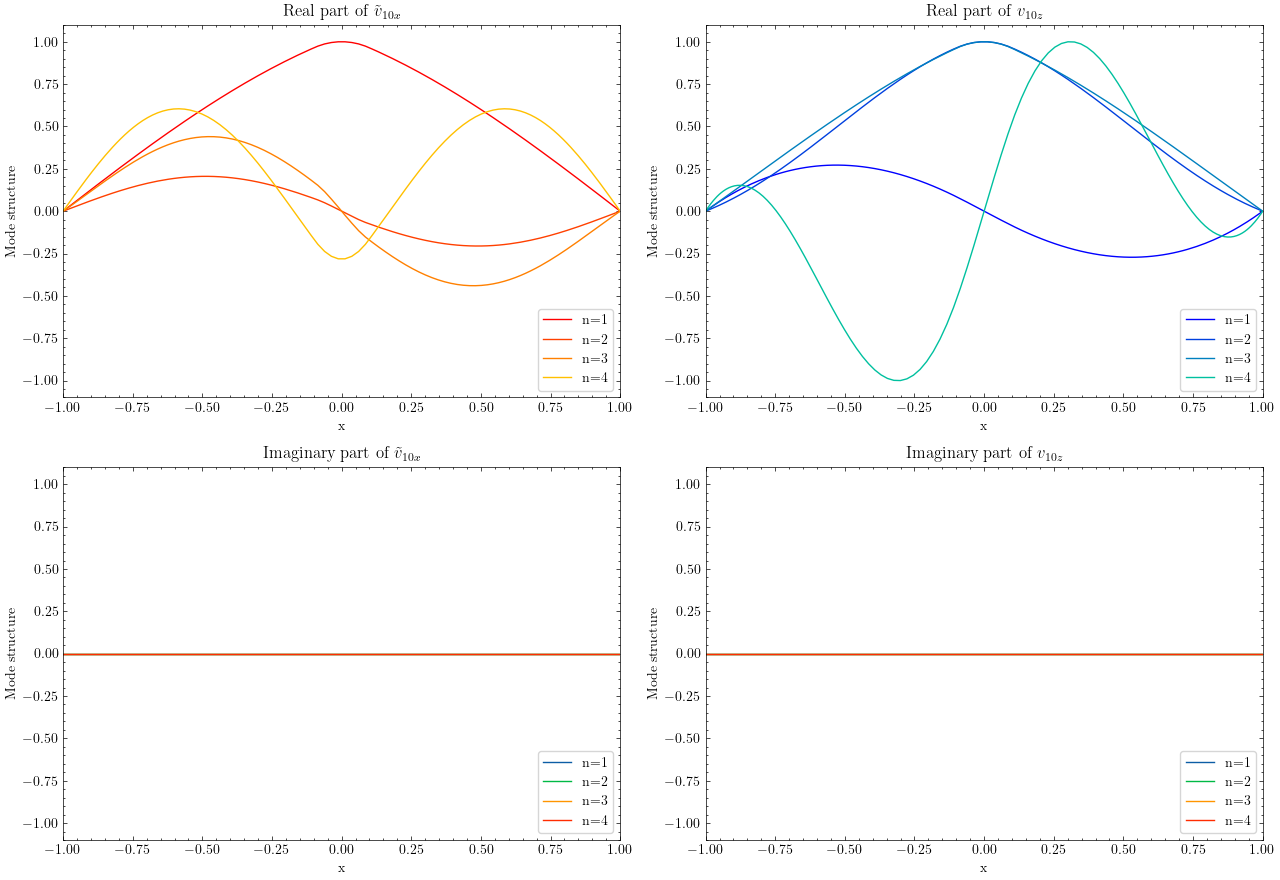

In [ ]:
### Create a figure and a 2x2 grid of subplots ###
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

### Plot real part of v10x~ ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is from ug; max_val =", max_val)
    else:
        print("Maximum value is from wg; max_val =", max_val)

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[0, 0].plot(x, ug/np.max(np.abs(max_val)), label=f"n={n}", color=colors_warm[n - 1])
axs[0, 0].set_ylim(-1.1, 1.1)
axs[0, 0].set_xlim(-1, 1)
axs[0, 0].legend(loc="lower right", frameon=True)
axs[0, 0].set_ylabel(r"Mode structure")
axs[0, 0].set_xlabel(r"x")
axs[0, 0].set_title(r"Real part of $\tilde{v}_{10x}$") # idò és imaginària ---> desfassament temporal de 1/4 de període

### Plot imaginary part of v10x~ ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag
    wi = w['g'].imag

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[1, 0].plot(x, ui/np.max(np.abs(max_val)), label=f"n={n}")
axs[1, 0].set_ylim(-1.1, 1.1)
axs[1, 0].set_xlim(-1, 1)
axs[1, 0].legend(loc="lower right", frameon=True)
axs[1, 0].set_ylabel(r"Mode structure")
axs[1, 0].set_xlabel(r"x")
axs[1, 0].set_title(r"Imaginary part of $\tilde{v}_{10x}$") # idò és real ---> desfassament temporal de 1/4 de període



### Plot real part of v10z ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[0, 1].plot(x, wg/np.max(np.abs(max_val)), label=f"n={n}", color=colors_cold[n - 1])
axs[0, 1].set_ylim(-1.1, 1.1)
axs[0, 1].set_xlim(-1, 1)
axs[0, 1].legend(loc="lower right", frameon=True)
axs[0, 1].set_ylabel(r"Mode structure")
axs[0, 1].set_xlabel(r"x")
axs[0, 1].set_title(r"Real part of ${v}_{10z}$")

### Plot imaginary part of v10z ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag
    wi = w['g'].imag

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val
    
    axs[1, 1].plot(x, wi/np.max(np.abs(max_val)), label=f"n={n}")
axs[1, 1].set_ylim(-1.1, 1.1)
axs[1, 1].set_xlim(-1, 1)
axs[1, 1].legend(loc="lower right", frameon=True)
axs[1, 1].set_ylabel(r"Mode structure")
axs[1, 1].set_xlabel(r"x")
axs[1, 1].set_title(r"Imaginary part of ${v}_{10z}$")

plt.tight_layout()
plt.show()

In [63]:
# Externs - defora major
# Interns - dedins ~ defora

# Realció de dispersió

2025-05-01 10:56:41,009 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s
2025-05-01 10:56:41,689 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2025-05-01 10:56:42,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s
2025-05-01 10:56:43,470 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s
2025-05-01 10:56:44,472 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2025-05-01 10:56:45,373 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s
2025-05-01 10:56:46,172 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2025-05-01 10:56:46,948 subsystems 0/1 INFO :: Building subproblem matrices 

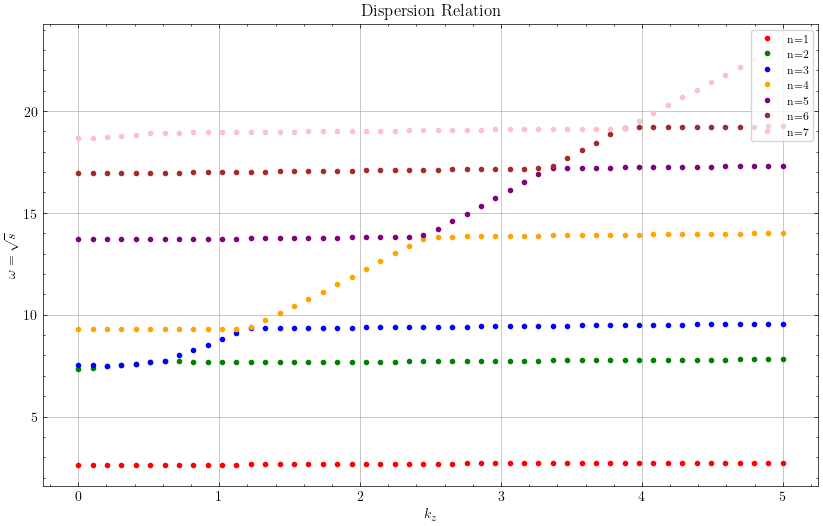

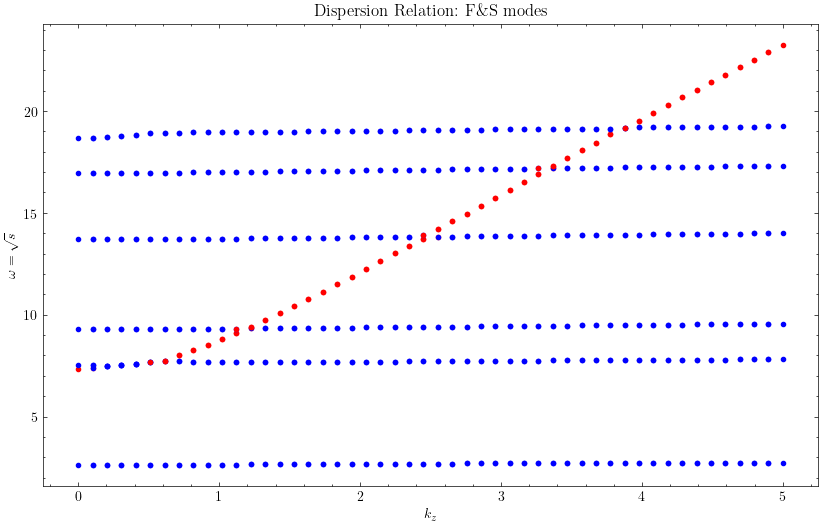

In [ ]:
Nkz = 50 # Nombre de kz's
kz_list = np.linspace(0, 5, Nkz) # Hi ha Nkz's separats equidistantment entre 0 i 5
### Relació de dispersió ###
plt.figure(figsize=(10, 6))
evals_k = np.zeros((kz_list.size, evals.size), dtype=np.complex128)
for ik, kz in enumerate(kz_list):
    problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals())
    problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
    problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
    problem.add_equation("u(x=xmin) = 0")
    problem.add_equation("u(x=xmax) = 0")
    problem.add_equation("w(x=xmin) = 0")
    problem.add_equation("w(x=xmax) = 0")

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])

    evals_k[ik, :] = np.sort(solver.eigenvalues)

# Plot dispersion relation of the first 8 eigenvalues
for i in range(7):
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
    plt.plot(kz_list, np.sqrt(evals_k[:, i].real), '.', label=f"n={i+1}", color=colors[i % len(colors)])
plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega = \sqrt{s}$")
plt.title("Dispersion Relation")
plt.grid(True)    
plt.legend(loc="upper right", frameon=True, fontsize=8)
plt.show()

# Per veure amb més detall la relació de dispersió de cada mode la representam individualment.
#for i in range(7):
#    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
#    plt.plot(kz_list, np.sqrt(evals_k[:, i].real), '.', label=f"Mode {i+1}", color=colors[i % len(colors)])
#    plt.xlabel(r"$k_z$")
#    plt.ylabel(r"$\omega = \sqrt{s}$")
#    plt.title(f"Dispersion Relation for n = {i+1}")
#    plt.grid(True)
#    plt.show()
#plt.show()

# Baixar kz entre 1 i 1.5 per veure en detall es canvi!

# Inicialitzar un diccionari per emmagatzemar els valors de kz on es produeix l'increment dràstic
drastic_increase_points = {}

# Definir un llindar per detectar increments dràstics
threshold = 0.75  # Ajustar segons sigui necessari

# Iterar sobre cada mode
for i in range(7):
    omega = np.sqrt(evals_k[:, i].real)
    kz_values = kz_list

    # Calcular la derivada discreta de omega respecte a kz
    d_omega_d_kz = np.diff(omega) / np.diff(kz_values)

    # Trobar els índexs on la derivada supera el llindar
    indices = np.where(d_omega_d_kz > threshold)[0]

    # Crear un array per classificar cada interval segons el llindar
    is_drastic = d_omega_d_kz > threshold  # True si increment dràstic, False si suau

    # Emmagatzemar els valors de kz corresponents als increments dràstics

    drastic_increase_points[f"Mode {i+1}"] = kz_values[indices + 1]  # +1 perquè diff redueix la longitud en 1
    # Imprimir els resultats
    #print(f"Mode {i+1}: Increment dràstic a kz = {drastic_increase_points[f'Mode {i+1}']}")


colors_per_mode = {
    "Mode 1": ["blue"],
    "Mode 2": ["red", "blue", "blue","blue"],
    "Mode 3": ["blue", "red", "blue","blue"],
    "Mode 4": ["blue", "red", "blue","blue"],
    "Mode 5": ["blue", "red", "blue","blue"],
    "Mode 6": ["blue", "red", "blue","blue"],
    "Mode 7": ["blue", "blue", "blue","red"],}
# No està gaire ben fet pq només ens serveix per 7 modes... però bé

plt.figure(figsize=(10, 6))
for i in range(7):
    omega = np.sqrt(evals_k[:, i].real)
    kz_values = kz_list

    # Derivada discreta
    d_omega_d_kz = np.diff(omega) / np.diff(kz_values)

    # Classificació suau / dràstic
    is_drastic = d_omega_d_kz > threshold

    mode_label = f"Mode {i+1}"
    assigned_colors = colors_per_mode.get(mode_label, ["blue"])  # Default color black if missing

    # Controlar l'índex dels colors
    color_idx = 0

    for j in range(len(d_omega_d_kz)):
        if color_idx >= len(assigned_colors):
            color = "blue"  # Per seguretat, si falten colors
        else:
            color = assigned_colors[color_idx]

        plt.plot(kz_values[j:j+2], omega[j:j+2], '.', color=color, linewidth=2)

        # Només canviem de color si hi ha un canvi de zona
        if j < len(d_omega_d_kz) - 1:
            if is_drastic[j] != is_drastic[j+1]:
                color_idx += 1

# kz_list ens dona una llista amb els valors de kz equidistants entre 0 i 5
# kz_inc ens dona una llista amb els valors de kz on es produeix l'increment dràstic

# El que vull fer és definir un valor de llindar per detectar increments dràstics en la relació de dispersió
# i després definir una funció a trossos per separar les zones amb increments dràstics i sense increments dràstics
# i representar-ho en el gràfic de la relació de dispersió.

plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega = \sqrt{s}$")
plt.title(r"Dispersion Relation: F\&S modes")
#plt.ylim(8,10)
#plt.legend(loc="upper right", frameon=True, fontsize=8)
plt.grid(False)
plt.show()

################################ Representar autofuncions aprop del canvi de comportament per estudiar com canvia

# Ampliació a un canvi de comportament en la relació de dispersió

# Provam amb valors realistes (Monxo)

Number of unknowns: 6
Number of equations: 6
2025-05-01 14:33:29,026 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2m 14s, Remaining: 0s, Rate: 7.4e-03/s
evals.size (before)  516
evals.size (after removing inf)  516
evals.size (after removing < 0)  500

evals size 500
true_evals size  500
First 5 Eigenvalues (sqrt): [   6171.39290812   39469.28626158  539494.34517184  554067.7634492
 1109071.67557456]
First 5 True eigenvalues: [38143.08165538 38143.08165539 38143.0816554  38143.08165541
 38143.08165542]
Relative error: [ 0.83820413  0.0347692  13.14396325 13.52603564 28.07661435]

Maximum value is from wg; max_val = 1.685762524238594
Maximum value is from ug; max_val = 1.6857625789086148
Maximum value is from ug; max_val = 62.743581407060006
Maximum value is from wg; max_val = 540.4395990683846


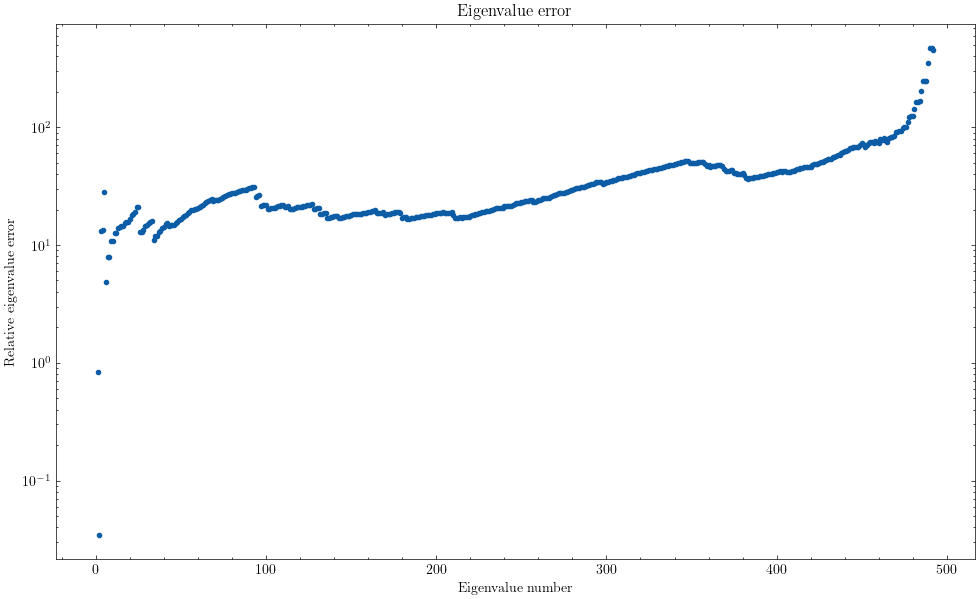

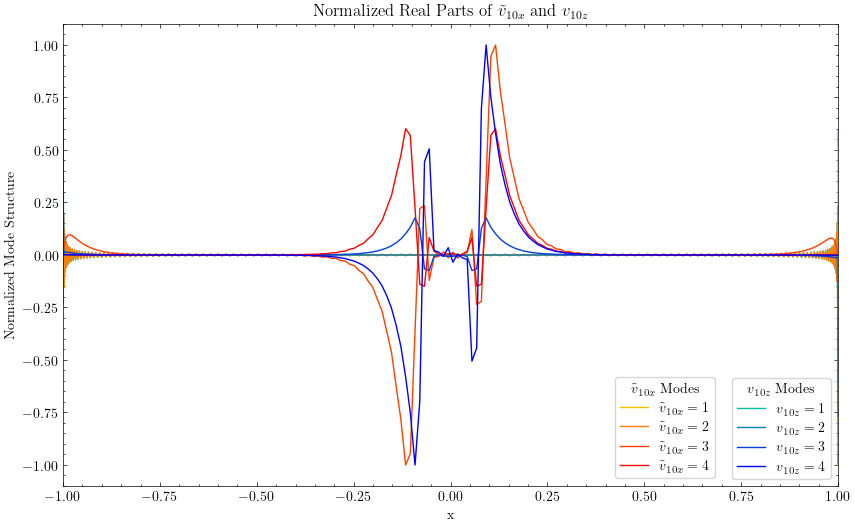

Valors normalitzats:


,Mode,ug_max,wg_max,ug_min,wg_min
0,Mode 1,0.593688,1.000000,-0.127629,-1.000000
1,Mode 2,1.000000,0.782642,-1.000000,-0.770741
2,Mode 3,1.000000,0.176766,-0.999999,-0.074018
3,Mode 4,0.601732,1.000000,-0.148703,-1.000000


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
logger = logging.getLogger(__name__)
from IPython.display import display
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

def dispersion_relation2(omega):
    disprel_even2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
    disprel_odd2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
    disprel2 = disprel_even2 * disprel_odd2
    return disprel2

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        sol2 = fsolve(dispersion_relation2, omega0)

        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        if sol2 > 0:
            exact_soln = np.append(exact_soln, sol2)
            exact_soln = np.unique(exact_soln.round(decimals=8))

        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
#    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln



""" Paràmetres """
Nx = 128*2 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]



""" Constants """
kz = 1
#B0 = 0

### Velocitats a trossos ###
cp2 = 137724550.89820358 # 1
cc2 = 27544910179.640717 # 6
vAp2 = 3978873577.297384 # 9
vAc2 = 795774715459.4768 # 36
# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768



""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ###
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis)

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Camps magnètics ###
#Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
#Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z

### Densitats ###
#rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma  ρ0
#rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
#rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')



""" Derivatives """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!

# RESOLDRE PRIMER SUBSTITUINT Bx, Bx i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w, eqs. (17') i (19')

# velocitat dedins menor que defora
# alfven major primer, després provar

# comparar amb kz = 0 les dues equacions han de ser ~ iguals
# provar amb kz = 0.01 i s'ha de modificar poc - petit acoblament de les velocitats



""" Problem """
### Problema d'ones ràpida i lenta (complet) ###
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

### Problema d'ones d'Alfvén ### ~ corda guitarra amb densitat variable
#problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)

### Problema d'ones ràpida i lenta (més treballat) ###
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals()) # 2 equacions i 4 incògnites
# problem.add_equation("s * u  +  c2 * uxx  =  0") # (17') # amb kz = 0
# problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0. Hauríem d'obtenir una molt semblant a la (17') però amb la velocitat en z i la constant d'Alfvén
problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))



""" Solve """
### Solver de Dedalus ###
solver = problem.build_solver()
#print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

### Ajustament de les autofuncions ###
print('evals.size (before) ', evals.size)
#evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

### Autovalors exactes ###
Nevals = evals.size
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
true_evals = exact_soln[0:evals.size]

### Error relatiu ###
relative_error = np.abs(evals - true_evals) / true_evals

### Autovalors ###
print('evals size', evals.size)
print("true_evals size ", true_evals.size)
#print("Evals", evals)
#print("True Evals", true_evals)

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])
print()  # This adds a blank line



""" Plot """
### Plot error ###
plt.figure(figsize=(10, 6))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Eigenvalue number")
plt.ylabel("Relative eigenvalue error")
plt.tight_layout()
plt.title("Eigenvalue error")
plt.grid(False)
plt.plot()



### Nombre de modes que volem representar ###
N_max_mode = 4
N_min_mode = 0
N_modes = N_max_mode - N_min_mode

### Define warm and cold color palettes ###
cmap_warm = plt.get_cmap('autumn')  # Warm color palette for v10x~
cmap_cold = plt.get_cmap('winter')   # Cold color palette for v10z
colors_warm = [cmap_warm(i / N_modes) for i in range(N_modes)]    # Warm colors
colors_cold = [cmap_cold(i / N_modes) for i in range(N_modes)]    # Cold colors

### Create lists to store handles for legends ###
handles_v10x = []
handles_v10z = []

### Plot ug.real and wg.real and normalize to the maximum value ###

x = dist.local_grid(xbasis)
ug_max_list = []
ug_min_list = []
wg_max_list = []
wg_min_list = []
plt.figure(figsize=(10, 6))
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag/(u['g'][1]).imag
    wi = w['g'].imag/(w['g'][1]).imag
    
    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is from ug; max_val =", max_val)
    else:
        print("Maximum value is from wg; max_val =", max_val)

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    # Append the values to the lists to display in the DataFrame
    ug_max_list.append(np.max(ug_normalized))
    ug_min_list.append(np.min(ug_normalized))
    wg_max_list.append(np.max(wg_normalized))
    wg_min_list.append(np.min(wg_normalized))

    # Plot v10x~ with warm colors and store the handle
    handle_v10x, = plt.plot(x, ug_normalized, label=fr"$\tilde{{v}}_{{10x}}={n}$", color=colors_warm[ - n])
    handles_v10x.append(handle_v10x)

    # Plot v10z with cold colors and store the handle
    handle_v10z, = plt.plot(x, wg_normalized, label=fr"${{v}}_{{10z}}={n}$", color=colors_cold[ - n])
    handles_v10z.append(handle_v10z)

    # Create a DataFrame to display the results
    data = {
        "Mode": [f"Mode {i+1}" for i in range(len(ug_max_list))],
        "ug_max": ug_max_list,
        "wg_max": wg_max_list,
        "ug_min": ug_min_list,
        "wg_min": wg_min_list,}
    df = pd.DataFrame(data)

## Create separate legends
legend_v10x = plt.legend(handles=handles_v10x, title=r"$\tilde{v}_{10x}$ Modes", loc="upper right", bbox_to_anchor=(0.85, 0.25), frameon=True)
plt.gca().add_artist(legend_v10x)  # Add the first legend to the plot
plt.legend(handles=handles_v10z, title=r"$v_{10z}$ Modes", loc="lower right", bbox_to_anchor=(1, 0), frameon=True)

plt.xlim(-1, 1)
#plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Normalized Mode Structure")
plt.xlabel(r"x")
plt.title(r"Normalized Real Parts of $\tilde{v}_{10x}$ and ${v}_{10z}$")
plt.grid(False)
plt.show()
print("Valors normalitzats:")
display(df)


# Tal vegada em pot interessar normalitzar en un bucle i després representar per separat. No representar tot de cop... però sí pq les vull comparar en tamany...


# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z. També que v10x és imaginària i v10z és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.

# Ficar els plots de les velocitats dins el for i representar les velocitats per cada kz... pot tardar bastant però crec que és el que he de fer!

# No entenc molt bé perquè els modes no es van alternant, és a dir, els modes senars el màxim hauria de ser ug i els parells wg; NO ESTÀ PASSANT AIXÒ PERÒ!

In [39]:
# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768
cp2 = 137724550.89820358
cc2 = 27544910179.640717
vAp2 = 3978873577.297384
vAc2 = 795774715459.4768

print("Valors realistes:")
print("cp2 =",cp2)
print("cc2 =",cc2)
print("vAp2 = ",vAp2)
print("vAc2 =",vAc2)
print()

print("Relacions entre velocitats:")
print("cc2/cp2 = ",cc2/cp2)
print("vAc2/vAp2 = ",vAc2/vAp2)
print("vAp2/cp2 = ",vAp2/cp2)
print("vAc2/cc2 = ",vAc2/cc2)
print()
print("vAp2/cc2 = ",vAp2/cc2)
print("vAc2/cp2 = ",vAc2/cp2)
print("vAp2/vAc2 = ",vAp2/vAc2)
print("vAc2/vAp2 = ",vAc2/vAp2)

Valors realistes:
cp2 = 137724550.89820358
cc2 = 27544910179.640717
vAp2 =  3978873577.297384
vAc2 = 795774715459.4768

Relacions entre velocitats:
cc2/cp2 =  200.0
vAc2/vAp2 =  200.0
vAp2/cp2 =  28.890082061246225
vAc2/cc2 =  28.890082061246225

vAp2/cc2 =  0.14445041030623113
vAc2/cp2 =  5778.016412249245
vAp2/vAc2 =  0.005
vAc2/vAp2 =  200.0
